#Introduction

This Colab Notebook is the work and submission of Stephen Otten, part of Group 1 for the CS 3793.001 Artificial Intelligence Group Projects of the Spring 2022 semester.

This notebook implements a NLP model in the goal of text classification to identify Fake and Real news articles from a dataset. The general idea for the model comes from this reserach pdf: https://iopscience.iop.org/article/10.1088/1742-6596/2007/1/012047/pdf

The NLP model, in basic, loads a formatted dataset and splits it up for training and testing portions. The words of the articles in the dataset will be turned into a matrix of words with a TF-IDF vectorizer. Finally, the model will use a Passive Aggressive Classifier in order to classify and predict the outcome of whether each article in the testing set is real or fake, the results are then analyzed to draw conclusions. 

#IMPORTED LIBRARIES





In [ ]:
#Import libraries and connect to google drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#The basepath is the same as what it is in the class assignments for simplicity
basePath = "/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Data/"

##Data files used, and how the files are structured

The Dataset used for this Machine Learning Model is a Kaggle Dataset consisting of Fake and Real news articles, formatted in 'csv' files. 

The link to the dataset is: https://www.kaggle.com/c/fake-news/data?select=test.csv

Downloading the dataset will give you two file "train.csv" and "test.csv". For simplicities sake, the contents of both datasets will get combined into one larger data set in which the Model will be trained and tested with.

As shown above, during the making of this Notebook the train and test csv files where loaded into the base path directory that was used for all class assignment. This was done for consistancy with the class and for simplicity.

In [ ]:
# Data file name variables
train = basePath + "train.csv"
test = basePath + "test.csv"

The CSV files come foramtted with 5 total columns. The columns are 'id', 'title', 'author', 'text', and 'label'. 

    ID: The designation number of the article in the file
    Title: Title of the associated news article
    Author: Person who wrote the News article
    Text: All words of the news article 
    Label: Designation of whether the news article is reliable or unreliable. O means unreliable, 1 means reliable. (These essentially refer to Fake or Real)

'Train.csv' has 20799 rows in it by default. 'Test.csv' has 25999 rows in it by default.

##Formatting the Data

In order to use data of the files, it has to be prepared and formatted in a certain manner. This invovles scrubbing the id, title, and author columns from the both datasets. Also, any rows with NAN values need to be removed entirely as they are unsuitable. 

The next step involves combining the contents of the train and test datasets into one final dataset that will be used for the Machine Learning portion of the notebook.

In [ ]:
# 0 = reliable, 1 = unreliable

# Read the training file
data_train = pd.read_csv( train )
data_train = data_train.drop(['id','author','title'], 1)
data_train.dropna( inplace=True) 
data_train.reset_index(inplace = True, drop = True)
print( data_train.shape )

# Read the testing data file
data_test  = pd.read_csv( test )
data_test = data_test.drop(['id','author','title'], 1)
data_test.dropna( inplace=True) 
data_test = data_test.loc[ :, :'label']
data_test.reset_index(inplace = True, drop = True)
print( data_test.shape )

# Combine both train and test datasets into a final dataset which is used later on
dataset = pd.concat( [data_train, data_test], ignore_index=True)
print( dataset.shape)
dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


(20761, 2)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264

(1, 2)
(20762, 2)


,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0
1,Ever get the feeling your life circles the rou...,0.0
2,"Why the Truth Might Get You Fired October 29, ...",1.0
3,Videos 15 Civilians Killed In Single US Airstr...,1.0
4,Print \nAn Iranian woman has been sentenced to...,1.0


#Check the final dataset to make sure it is valid for usage

The final dataset that will be used has 2 columns of "text" and "label". There are about 20762 total rows in the dataset, with about a 50:50 percent split between Fake and Real articles in the set. These statistics are shown below. 

0.0    10388
1.0    10374
Name: label, dtype: int64


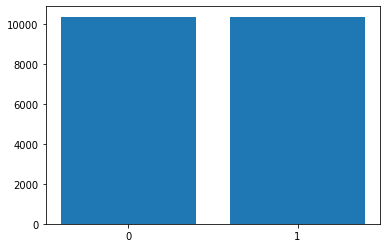

In [ ]:
#graph the total number of fake and real articles in the final dataset
real_or_not = dataset.label.value_counts()
print( real_or_not )

plt.figure()
plt.bar( ['0','1'], real_or_not )
plt.show()

The dataset is lastly checked so that no NaN values are present. The ouptut of the next cell is empty because there are no NaN values present.

In [ ]:
dataset[dataset.isnull().any(axis=1)]

,text,label


##Supervised Machine Learning 

From this point on is where the actual Machine Learning and predictions of the Notebook will occur.

The next cell includes a helpful function which will be used later to display the results of the machine learning on the testing set in a understandable manner (Hargurjeet).



In [ ]:
#A helpful function pulled from a websitethat will print out the results of the Models processing in a concise and understandable manner.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Split the dataset into testing and training
The next cell shows the dataset being partitioned into training, and testing sets ( 80% for training, 20% for testing ) that will be used for the Model.

In [ ]:
y = dataset['label']
xtrain, xtest, ytrain, ytest = train_test_split( dataset['text'], y, test_size=0.2, random_state=7)

#TF-IDF Vectorizer
The model uses a TF-IDF vectorizer in order to determine the importance of words. TF is 'term frequency' which totals the occurances of a word across an entire article. IDF is 'inverse document frequency' which looks for the total occurances of words across all the news articles (Wadhwa). TF-IDF works by constructing a matrix of the most common words used in all the documents and totaling the occurances of each word. The matrix constructed of all term frequencies is used later in the model to identify term importance. 

In [ ]:
TF_matrix = TfidfVectorizer( stop_words='english', max_df=0.7)

TF_train = TF_matrix.fit_transform( xtrain )
TF_test = TF_matrix.transform( xtest )

#Passive Aggressive Classifier
The Model uses a Passive-Aggressive Classifier in order to make predictions on the testing portion of the dataset, after being trained with the training set.

Passive Aggressive operates by being passive when predictions are correct and no changes need to be made to the Model. It is aggressive when classification predictions are wrong and changes to the model need to be made (Wadhwa).

In [ ]:
PA_model = PassiveAggressiveClassifier( max_iter = 50)
PA_model.fit( TF_train, ytrain)

PassiveAggressiveClassifier(max_iter=50)

#Model Results and Conclusions
The results of the Model come out with around a ~95% accuracy. This is after running the test on the dataset multiple times. The model runs remarkably well possibly due in part to the size of dataset being not very big. The training the model underwent with 80% of the dataset seems to have given the model a very good idea of what it needs to look for in discerning real from fake news articles.

Total Predictions Made: 4153
Accuracy: 0.960
Confusion matrix, without normalization


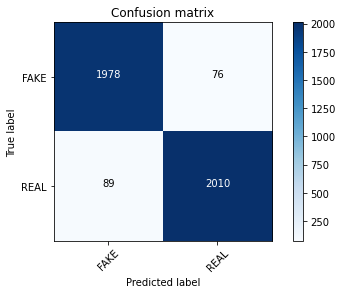

In [ ]:
#Total predictions made with the testing set
print( "Total Predictions Made:", ytest.shape[0])

#accuracy of the testing
#accuracy shows in total how many predictions were correct
y_prediction = PA_model.predict( TF_test )
accuracy = accuracy_score( ytest, y_prediction )
print( "Accuracy: %0.3f" %accuracy )


#plot the confusion matrix
confuse_matrix = confusion_matrix( ytest, y_prediction )
plot_confusion_matrix(confuse_matrix, classes = ['FAKE','REAL'])

#Conclusion: What was learned

The results gathered from the Model working on the testing set show that this model has promise in discerning Fake news articles from Real news articles. The results also imply that this Model could be used for discerning variations of other types of texts, not just real or fake news articles.

TF-IDF Word Vectorization is a well renowed way of categorizing the importance of words across a group of documents. It is well suited to use in a ML model to guage the importance of words across all of the articles. This helps associate which words are likely to be used in the search for fake or real news.

The Passive Aggressive Classifier is not the best or first option that is usually used for ML models. This classifier is situationally used in which other classifiers might bot be preferable. Passive Aggressive seems like an optimal choice to combine with TF-IDF Word vectorization. The classifier can make very good predictions based on the data heavy word matrix that is formed from TF-IDF. The classifier also makes good use of its corrective aspect, always making changes to the model when predictions are found to be wrong.

For datasets that are much larger than the set used for this notebook, I suspect that the Model would continue to do its job rather well in making correct predictions. The Passive Aggressive classifier is inherently designed to always be taking in new or more data to process and always adapt the model to the new data if changes need to be made (Passive Aggressive Classifiers). It would be worth it to train the model on a much larger dataset and then let the model continuously run with those training weights and make changes on its own. The Passive Aggressive classifier is a very good choice in NLP where it involves classification of a body of text to a type.

Works Cited:

J. Shobana and D. Kanchana 2021 J. Phys.: Conf. Ser. 2007 012047


https://www.kaggle.com/c/fake-news/data?select=test.csv


George, Joyce. “Fake News Detection using NLP techniques”, Medium, 14 Jun 2020.	https://medium.com/analytics-vidhya/fake-news-detection-using-nlp-techniques-	c2dc4be05f99. Accessed April 8, 2022.

Hargurjeet. “NLP – Detecting Fake News on Social Media”, Medium, 9 Jun 2021.	https://medium.com/mlearning-ai/nlp-detecting-fake-news-on-social-media-	aa53ff74f2ff#d7e7. Accessed April 8, 2022.

“Passive Aggressive Classifiers”, GeeksforGeeks, 17 Jul, 2020. 	https://www.geeksforgeeks.org/passive-aggressive-classifiers/. Accessed April 10, 2022.

Sriram. “Passive Aggressive Algorithm – For Big Data models”, Medium, 13 Jun 2021. 	https://medium.com/geekculture/passive-aggressive-algorithm-for-big-data-models-	8cd535ceb2e6. Accessed April 7, 2022.

Wadhwa, Laisha. “Detecting Fake Political News Online”, Towards Data Science, 16 Nov, 	2019. https://towardsdatascience.com/detecting-fake-political-news-online-	a571745f73dd. Accessed April 11, 2022.
